In [1]:
import sys  
sys.path.insert(0, './machine_learning_models')

import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from helpers import stats as bf, file as fh, classification as pf
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from helpers.file import save_file
from joblib import dump
pd.set_option('mode.chained_assignment', None)

Setup Complete


In [34]:
start_season = 2012

random_state = 0

n_last_games = 10
n_last_specific_games = 5
betting_starts_after_n_games = 0

selected_models = ["gradient_boosting", "logistic_regression"]
preprocess = False
min_odds = 2.4
bankroll = 900
strategy = "default"
default_value = 1
default_bankroll_pct = 0.05

plot_threshold = 0

features = ["home_odds", "away_odds",
    "home_pts", "home_pts_con", "home_fg_pct", "home_fg3_pct", "home_ft_pct", "home_reb", "home_tov", "home_season_pct",
    "home_per", "home_elo", "home_matchup_pct", "home_ha_pct", "home_streak", "home_last_games_pct", "home_ha_last_games_pct",
    "home_off_rtg", "home_def_rtg", "home_is_b2b",
    "away_pts", "away_pts_con", "away_fg_pct", "away_fg3_pct", "away_ft_pct", "away_reb", "away_tov", "away_season_pct",
    "away_per", "away_elo", "away_matchup_pct", "away_ha_pct", "away_streak", "away_last_games_pct", "away_ha_last_games_pct",
    "away_off_rtg", "away_def_rtg", "away_is_b2b",]

In [3]:
season_games, season_games_players, teams, teams_elo = bf.initialize_matches(start_season)

display(season_games[["date", "home_team", "away_team", "home_elo", "away_elo"]])

Generating teams ELOs...


100%|██████████| 15025/15025 [00:04<00:00, 3096.28it/s]

Successfully generated teams ELOs.


,date,home_team,away_team,home_elo,away_elo
0,2012-10-30,Cleveland Cavaliers,Washington Wizards,1500.00,1500.00
1,2012-10-30,Miami Heat,Boston Celtics,1500.00,1500.00
2,2012-10-30,Los Angeles Lakers,Dallas Mavericks,1500.00,1500.00
3,2012-10-31,Toronto Raptors,Indiana Pacers,1500.00,1500.00
4,2012-10-31,Philadelphia 76ers,Denver Nuggets,1500.00,1500.00
...,...,...,...,...,...
15020,2024-03-01,Memphis Grizzlies,Portland Trail Blazers,1391.02,1316.87
15021,2024-03-01,Minnesota Timberwolves,Sacramento Kings,1656.88,1521.41
15022,2024-03-01,New Orleans Pelicans,Indiana Pacers,1587.29,1545.58
15023,2024-03-01,Chicago Bulls,Milwaukee Bucks,1506.68,1581.97


In [4]:
print("Creating CSV file of all games")

teams_per = dict()

matches_organized = []
matches_organized_playoffs = []
season = ""

for i, g in tqdm(season_games.iterrows(), total=len(season_games)):
    season = g["season"]

    is_playoffs = int(g["is_playoff"])

    team_a_id = g["home_id"]
    team_b_id = g["away_id"]

    team_a_abbv = teams.loc[teams["id"] == team_a_id].iloc[0]["abbreviation"]
    team_b_abbv = teams.loc[teams["id"] == team_b_id].iloc[0]["abbreviation"]

    winner = g["winner"]

    # Update ELO after stats computed
    team_a_pts = g["home_pts"]
    team_b_pts = g["away_pts"]

    team_a_odds, team_b_odds = g["home_odds"], g["away_odds"]

    if not team_a_odds or not team_b_odds:
        continue

    stats_team_a = bf.get_game_data(
        season_games,
        season_games_players,
        teams_elo,
        g,
        team_a_id,
        team_b_id,
        teams_per,
        n_last_games,
        n_last_specific_games,
        "H",
    )
    if not stats_team_a:
        continue

    stats_team_b = bf.get_game_data(
        season_games,
        season_games_players,
        teams_elo,
        g,
        team_b_id,
        team_a_id,
        teams_per,
        n_last_games,
        n_last_specific_games,
        "A",
    )
    if not stats_team_b:
        continue

    match_info = bf.get_match_info(
        [season, g["date"], team_a_abbv, team_b_abbv, team_a_odds, team_b_odds],
        stats_team_a,
        stats_team_b,
        winner,
        team_a_pts,
        team_b_pts,
    )
    if is_playoffs:
        matches_organized_playoffs.append(match_info)
    else:
        matches_organized.append(match_info)

print(
    "Total matches: {}\nTotal playoffs matches: {}".format(
        len(matches_organized), len(matches_organized_playoffs)
    )
)

Creating CSV file of all games


100%|██████████| 15025/15025 [14:16<00:00, 17.54it/s]

Total matches: 12228
Total playoffs matches: 923


In [16]:
columns = [
    "season", "date", "home_team", "away_team", "home_odds", "away_odds",
    "home_pts", "home_pts_con", "home_fg_pct", "home_fg3_pct", "home_ft_pct", "home_reb", "home_tov", "home_season_pct",
    "home_per", "home_elo", "home_matchup_pct", "home_ha_pct", "home_streak", "home_last_games_pct", "home_ha_last_games_pct",
    "home_off_rtg", "home_def_rtg", "home_is_b2b",
    "away_pts", "away_pts_con", "away_fg_pct", "away_fg3_pct", "away_ft_pct", "away_reb", "away_tov", "away_season_pct",
    "away_per", "away_elo", "away_matchup_pct", "away_ha_pct", "away_streak", "away_last_games_pct", "away_ha_last_games_pct",
    "away_off_rtg", "away_def_rtg", "away_is_b2b",
    "result", "home_game_pts", "away_game_pts",
]

stats_df = fh.parse_df_to_csv(
    matches_organized, columns, "../data", f"{start_season}.csv"
)

fh.parse_df_to_csv(
    matches_organized_playoffs,
    columns,
    "../data/playoffs",
    f"{start_season}.csv",
)

display(stats_df)

,season,date,home_team,away_team,home_odds,away_odds,home_pts,home_pts_con,home_fg_pct,home_fg3_pct,...,away_ha_pct,away_streak,away_last_games_pct,away_ha_last_games_pct,away_off_rtg,away_def_rtg,away_is_b2b,result,home_game_pts,away_game_pts
0,2012,2012-11-17,PHX,MIA,3.20,1.36,99.3,105.0,0.4307,0.3241,...,0.500000,1,0.7,0.6,111.655660,107.418542,False,A,88,97
1,2012,2012-11-18,DET,BOS,2.46,1.56,93.0,99.8,0.4378,0.3553,...,0.600000,1,0.6,0.6,105.807366,104.982441,True,H,103,83
2,2012,2012-11-19,DAL,GSW,1.42,2.90,100.9,100.1,0.4627,0.3893,...,0.500000,-1,0.5,0.4,100.099647,102.401857,True,A,101,105
3,2012,2012-11-19,UTA,HOU,1.33,3.37,96.2,97.8,0.4370,0.3231,...,0.400000,-2,0.4,0.4,102.150776,102.700599,True,H,102,91
4,2012,2012-11-20,PHI,TOR,1.45,2.77,88.9,90.1,0.4109,0.4000,...,0.200000,1,0.3,0.2,100.874199,104.481087,False,H,106,98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12223,2023,2024-03-01,MEM,POR,1.87,1.95,102.3,112.8,0.4458,0.3609,...,0.214286,-9,0.1,0.2,105.833282,118.188582,False,A,92,122
12224,2023,2024-03-01,MIN,SAC,1.30,3.62,116.5,102.8,0.4793,0.3914,...,0.531250,-2,0.4,0.4,115.567015,119.231296,False,A,120,124
12225,2023,2024-03-01,NOP,IND,1.49,2.69,111.8,108.2,0.4821,0.3715,...,0.500000,1,0.7,0.6,118.697628,114.882359,False,H,129,102
12226,2023,2024-03-01,CHI,MIL,2.37,1.60,116.4,116.7,0.4634,0.3500,...,0.517241,4,0.6,0.6,114.665357,107.691833,True,A,97,113


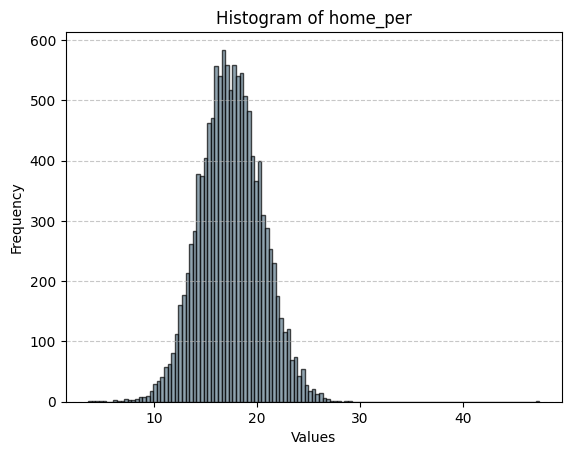

In [18]:
import matplotlib.pyplot as plt

column = 'home_per'

plt.hist(stats_df[column], bins='auto', alpha=0.7, color='#607c8e', edgecolor='black')

# Customize the plot
plt.title(f'Histogram of {column}')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

In [35]:
last_season = season_games.iloc[-1]["season"]

# Train and evaluate model
print("Training and evaluating models throughout the seasons...")
for season in tqdm(range(start_season + 1, last_season + 1)):
    season_games, trained_models = pf.simulate(
        stats_df,
        start_season,
        season,
        features,
        betting_starts_after_n_games,
        strategy,
        verbose=1,
        random_state=0,
        preprocess=preprocess,
        voting_classifier_models=selected_models
    )

Training and evaluating models throughout the seasons...


100%|██████████| 11/11 [07:16<00:00, 39.66s/it]


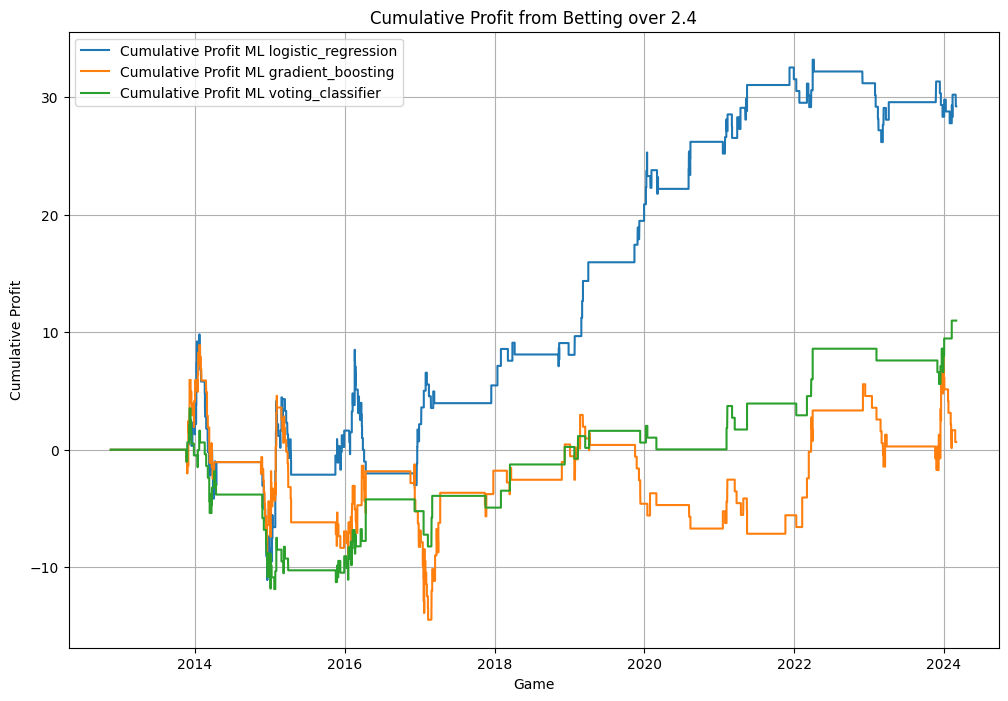

Home method (-106.07/2471): -0.0429
ML method with naive_bayes          --> ( -41.32/610): -0.0677
ML method with knn                  --> ( -48.34/1983): -0.0244
ML method with logistic_regression  --> (  29.19/220): 0.1327
ML method with svm                  --> (-106.07/2471): -0.0429
ML method with random_forest_default --> ( -27.42/215): -0.1275
ML method with random_forest        --> ( -13.61/ 79): -0.1723
ML method with gradient_boosting    --> (   0.66/232): 0.0028
ML method with ada_boost            --> (  -36.0/454): -0.0793
ML method with mlp                  --> (  -5.49/1789): -0.0031
ML method with voting_classifier    --> (  10.98/106): 0.1036

Profit for logistic_regression: $29.19
Accuracy for logistic_regression: 0.67
Classification Report for logistic_regression:
              precision    recall  f1-score   support

           A       0.65      0.51      0.57      4784
           H       0.68      0.79      0.73      6372

    accuracy                           0.67

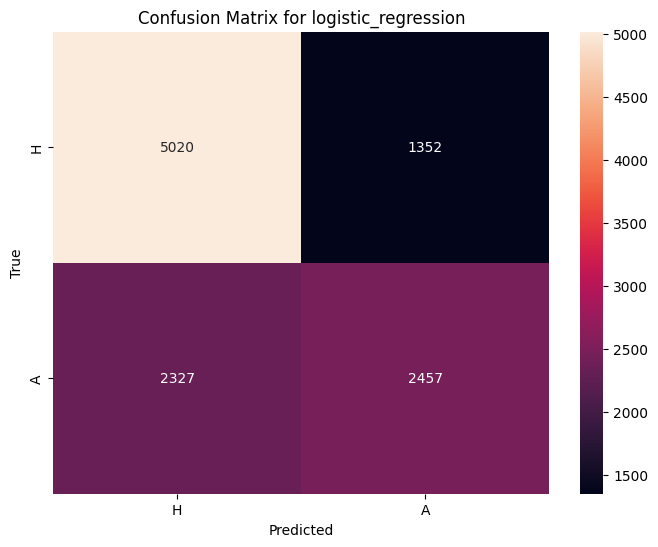

In [36]:
best_model_name = pf.get_simulation_results(season_games, start_season, min_odds, plot_threshold, random_state, bankroll, strategy, default_value, default_bankroll_pct)

In [21]:
first_season = 2012
last_season = 2023

first_season_simulation = 2014
last_season_simulation = 2023

save_models = False

season_file = f'{first_season}-{last_season}'













min_odds = 1.8

first_attr_index = 6
target_index = -3

In [22]:
print('\nGetting data for the model...')

dataset = pd.read_csv('../data/{}.csv'.format(season_file), index_col = 0)
dataset = dataset.loc[(dataset['ODDS_A'].notna()) & (dataset['ODDS_B'].notna())]
dataset['GAME_DATE'] = pd.to_datetime(dataset['GAME_DATE']).dt.date

display(dataset.tail(2))


Getting data for the model...


,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,IS_B2B_B,WINNER,GAME_PTS_A,GAME_PTS_B
12226,2023,2024-03-01,CHI,MIL,2.37,1.60,116.4,116.7,0.4634,0.3500,...,0.517241,4,0.6,0.6,114.665357,107.691833,True,A,97,113
12227,2023,2024-03-01,LAC,WAS,1.07,8.77,112.7,117.1,0.4730,0.3697,...,0.193548,-13,0.0,0.0,105.732753,116.419216,True,H,140,115


In [23]:
# dependent_variables = dataset.iloc[:,first_attr_index:]
# dependent_variables.corr()

In [24]:
def train_predict_model(x_train, y_train, x_test, y_test, season, model):
    model_abbv = model['abbreviation']
    classifier = model['classifier']
    
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    predictions_probabilities = classifier.predict_proba(x_test)
    
    if save_models and season == last_season:
        save_file('../models', classifier, model_abbv)
    
    results_df = pd.DataFrame({
        f"{model_abbv}_PRED": predictions,
        f"{model_abbv}_PROBS_A": predictions_probabilities[:, 1],
        f"{model_abbv}_PROBS_B": predictions_probabilities[:, 0],
    })
    
    return results_df

In [25]:
columns = dataset.columns[first_attr_index:target_index]

save_file('../columns', columns, 'original')

columns_to_drop = []
columns = [c for c in columns if c not in columns_to_drop]

save_file('../columns', columns, 'filtered')

target_col = dataset.columns[target_index]

print('Columns:', columns)
print('Target:', target_col)

Columns: ['PTS_A', 'PTS_CON_A', 'FG_PCT_A', 'FG3_PCT_A', 'FT_PCT_A', 'REB_A', 'TOV_A', 'SEASON_A_PCT', 'PER_A', 'ELO_A', 'MATCHUP_A_PCT', 'HA_A_PCT', 'STREAK_A', 'LAST_GAMES_PCT_A', 'HA_LAST_GAMES_PCT_A', 'OFF_RTG_A', 'DEF_RTG_A', 'IS_B2B_A', 'PTS_B', 'PTS_CON_B', 'FG_PCT_B', 'FG3_PCT_B', 'FT_PCT_B', 'REB_B', 'TOV_B', 'SEASON_B_PCT', 'PER_B', 'ELO_B', 'MATCHUP_B_PCT', 'HA_B_PCT', 'STREAK_B', 'LAST_GAMES_PCT_B', 'HA_LAST_GAMES_PCT_B', 'OFF_RTG_B', 'DEF_RTG_B', 'IS_B2B_B']
Target: WINNER


In [26]:
# import time
# import numpy as np

# start_time = time.time()
# importances = rf_classifier.feature_importances_
# std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_], axis=0)
# elapsed_time = time.time() - start_time

# forest_importances = pd.Series(rf_classifier.feature_importances_, index=columns)

# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=std, ax=ax)
# ax.set_title("Feature importances using MDI")
# ax.set_ylabel("Mean decrease in impurity")
# fig.tight_layout()

In [27]:
main_df = pd.DataFrame()

for season in range(first_season_simulation, last_season_simulation+1):
    rf_classifier = RandomForestClassifier(random_state=0)
    gb_classifier = GradientBoostingClassifier(random_state=0)
    lr_classifier = LogisticRegression()
    svm_classifier = SVC(kernel='rbf', random_state=0, probability=True)
    sgd_classifier = SGDClassifier(loss="log", random_state = 0)

    # Create a voting classifier
    voting_classifier = VotingClassifier(
        estimators=[
            ('LR', lr_classifier),
            ('SVM', svm_classifier),
            ('SGD', sgd_classifier),
            ('RF', rf_classifier),
        ],
        voting='soft'  # Use 'soft' for probability voting
    )
    
    models = [
        {'classifier': rf_classifier, 'abbreviation': 'RF'},
        {'classifier': gb_classifier, 'abbreviation': 'GB'},
        {'classifier': svm_classifier, 'abbreviation': 'SVM'},
        {'classifier': lr_classifier, 'abbreviation': 'LR'},
        {'classifier': voting_classifier, 'abbreviation': 'VC'},
        {'classifier': GaussianNB(), 'abbreviation': 'NB'},
        {'classifier': KNeighborsClassifier(), 'abbreviation': 'KNN'},
        {'classifier': sgd_classifier, 'abbreviation': 'SGD'}, 
    ]

    train_dataset = dataset[dataset['SEASON_ID'] < season]
    x_train = train_dataset[columns]
    y_train = train_dataset[target_col]

    test_dataset = dataset[dataset['SEASON_ID'] == season]
    x_test = test_dataset[columns]
    y_test = test_dataset[target_col]

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if save_models and season == last_season:
        save_file('../scalers', scaler, 'scaler')
    
    for model in models:
        clear_output(wait=True)
        
        model_abbv = model["abbreviation"]
        print(f"{season}/{last_season_simulation} - {model_abbv}")
        
        results_df = train_predict_model(x_train_scaled, y_train, x_test_scaled, y_test, season, model)
        results_df.set_index(test_dataset.index, inplace=True)
        
        test_dataset = pd.merge(test_dataset, results_df, left_index=True, right_index=True)

    if main_df.empty:
        main_df = test_dataset
    else:
        main_df = pd.concat([main_df, test_dataset], ignore_index=True)

2018/2023 - GB


KeyboardInterrupt: 

In [ ]:
def create_game_profit_col(row, model_abbv):
    odds = row["ODDS_A" if row[f"{model_abbv}_PRED"] == "H" else "ODDS_B"]
    pred_odds = 1 / (
        row[
            f"{model_abbv}_PROBS_A"
            if row[f"{model_abbv}_PRED"] == "H"
            else f"{model_abbv}_PROBS_B"
        ]
    )
    probs = row[
        f"{model_abbv}_PROBS_A"
        if row[f"{model_abbv}_PRED"] == "H"
        else f"{model_abbv}_PROBS_B"
    ]

    bet_valid = odds >= min_odds and pred_odds < odds

    if bet_valid and row["WINNER"] == row[f"{model_abbv}_PRED"]:
        return odds - 1
    elif bet_valid:
        return -1
    else:
        return 0


display(main_df.head(2))

in_depth_models_for_analysis = ["VC", "SGD", "RF"]

# Initialize an empty DataFrame to store season-wise statistics
season_stats = pd.DataFrame(columns=["Season"])

for model in models:
    model_abbv = model["abbreviation"]

    main_df[f"{model_abbv}_PROFIT"] = main_df.apply(
        lambda x: create_game_profit_col(x, model_abbv), axis=1
    )
    main_df[f"{model_abbv}_PROFIT_TRACKING"] = main_df[f"{model_abbv}_PROFIT"].cumsum()
    main_df[f"{model_abbv}_STRIKE"] = (
        main_df[f"{model_abbv}_PRED"] == main_df["WINNER"]
    ).astype(int)

    # Calculate Net Gains
    net_gains = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]

    # Calculate Yield
    total_profit = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]
    total_bets = len(main_df)
    yield_percentage = (total_profit / total_bets) * 100

    # Calculate Strike Rate
    correct_predictions = main_df[f"{model_abbv}_STRIKE"].sum()
    strike_rate_percentage = (correct_predictions / total_bets) * 100

    # Print the results
    print(f"\n{model_abbv} Net Gains: {net_gains}")
    print(f"{model_abbv} Yield: {yield_percentage:.2f}%")
    print(f"{model_abbv} Strike Rate: {strike_rate_percentage:.2f}%")

    if model_abbv not in in_depth_models_for_analysis:
        continue

    # Group by season and calculate overall stats
    model_season_stats = main_df.groupby("SEASON_ID").agg(
        {
            f"{model_abbv}_PROFIT_TRACKING": lambda x: x.iloc[-1] - x.iloc[0],
            f"{model_abbv}_PROFIT": lambda x: (
                x != 0
            ).sum(),  # Counting only non-zero profits as bets
        }
    )

    # Rename columns for clarity
    model_season_stats.columns = [f"{model_abbv}_Net_Gains", f"{model_abbv}_Total_Bets"]

    # Calculate additional statistics
    model_season_stats[f"{model_abbv}_Yield"] = (
        model_season_stats[f"{model_abbv}_Net_Gains"]
        / model_season_stats[f"{model_abbv}_Total_Bets"]
    ) * 100

    # Merge with the overall season_stats DataFrame
    season_stats = pd.merge(
        season_stats,
        model_season_stats,
        left_on="Season",
        right_index=True,
        how="outer",
    )

season_stats.drop("Season", axis=1, inplace=True)

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,VC_PROBS_B,NB_PRED,NB_PROBS_A,NB_PROBS_B,KNN_PRED,KNN_PROBS_A,KNN_PROBS_B,SGD_PRED,SGD_PROBS_A,SGD_PROBS_B
0,2014,2014-11-17,CHA,DAL,2.49,1.55,96.1,99.7,0.4343,0.3324,...,0.671484,A,0.007579,0.992421,A,0.2,0.8,A,0.178695,0.821305
1,2014,2014-11-17,DET,ORL,1.52,2.57,93.0,96.8,0.4192,0.3489,...,0.490447,A,0.214872,0.785128,A,0.2,0.8,H,0.585970,0.414030



RF Net Gains: -59.229999999999976
RF Yield: -0.59%
RF Strike Rate: 65.11%

GB Net Gains: -49.949999999999974
GB Yield: -0.50%
GB Strike Rate: 65.54%

SVM Net Gains: -56.70000000000001
SVM Yield: -0.56%
SVM Strike Rate: 65.38%

LR Net Gains: -56.31000000000002
LR Yield: -0.56%
LR Strike Rate: 66.45%

VC Net Gains: -9.830000000000059
VC Yield: -0.10%
VC Strike Rate: 66.47%

NB Net Gains: -109.61999999999999
NB Yield: -1.09%
NB Strike Rate: 64.67%

KNN Net Gains: -147.40000000000018
KNN Yield: -1.46%
KNN Strike Rate: 60.62%

SGD Net Gains: -33.02000000000001
SGD Yield: -0.33%
SGD Strike Rate: 64.02%


In [ ]:
display(season_stats)

,RF_Net_Gains,RF_Total_Bets,RF_Yield,VC_Net_Gains,VC_Total_Bets,VC_Yield,SGD_Net_Gains,SGD_Total_Bets,SGD_Yield
SEASON_ID,,,,,,,,,
2014,-26.05,209,-12.464115,-1.15,148,-0.777027,10.40,214,4.859813
2015,-0.54,203,-0.266010,-6.25,151,-4.139073,-17.03,219,-7.776256
2016,8.88,199,4.462312,22.31,188,11.867021,19.25,252,7.638889
2017,2.80,220,1.272727,-9.99,200,-4.995000,-36.15,321,-11.261682
2018,4.88,209,2.334928,14.98,191,7.842932,24.01,406,5.913793
2019,20.42,211,9.677725,12.59,165,7.630303,22.82,215,10.613953
2020,-18.49,226,-8.181416,-13.89,206,-6.742718,-11.24,216,-5.203704
2021,-13.70,206,-6.650485,-9.55,180,-5.305556,-16.97,257,-6.603113
2022,9.86,255,3.866667,14.57,203,7.177340,-9.81,273,-3.593407


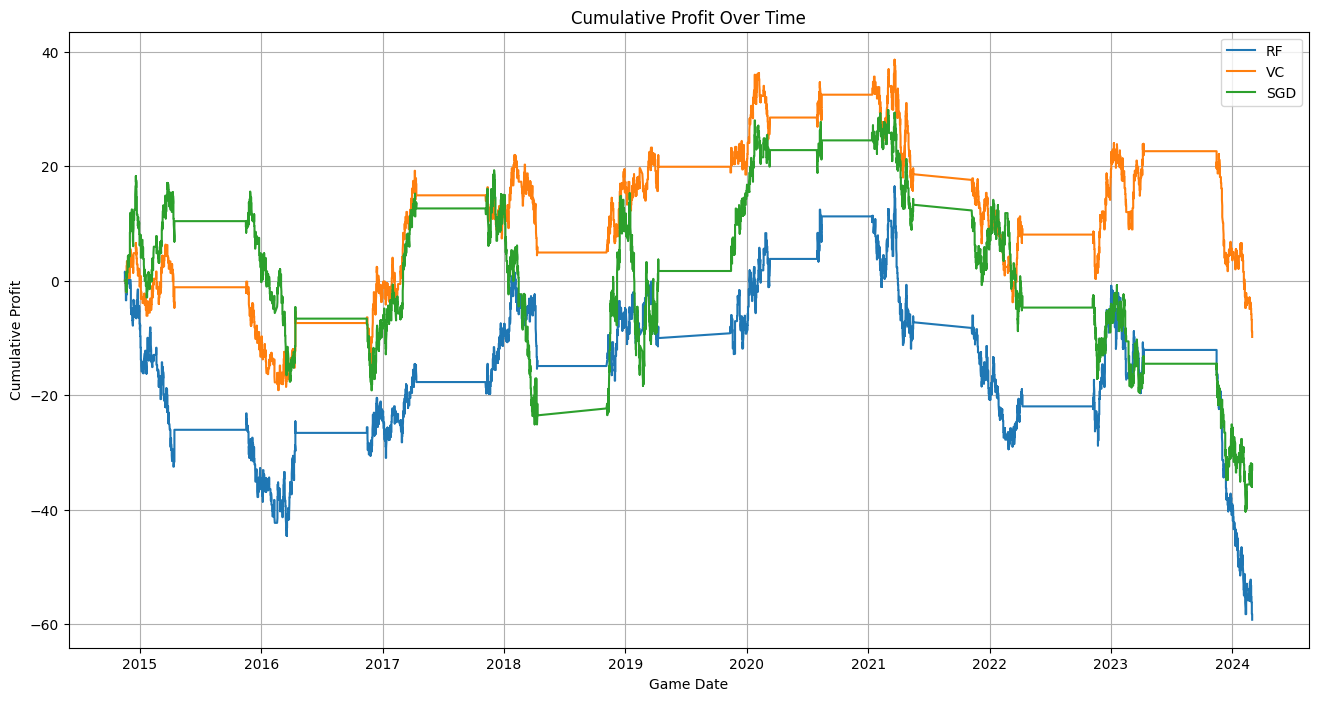

: 

In [ ]:
plt.figure(figsize=(16, 8))

for model in models:
    model_abbv = model["abbreviation"]
    if model_abbv in in_depth_models_for_analysis:
        plt.plot(main_df['GAME_DATE'], main_df[f"{model_abbv}_PROFIT_TRACKING"], label = model_abbv)
    
plt.title('Cumulative Profit Over Time')
plt.xlabel('Game Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)
plt.show()

#### 